<a href="https://colab.research.google.com/github/rajatha94/faiProject/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.python.client import device_lib
!cat /proc/meminfo | egrep "MemTotal*"

MemTotal:       13333556 kB


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time
from tensorflow.keras import layers
from collections import defaultdict

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 150
NOISE_DIMENSION = 100
NUM_OUTPUT = 16

gen_losses = defaultdict(list)
disc_losses = defaultdict(list)

In [0]:
def discriminator_loss(real_output, fake_output, epoch):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    disc_losses[epoch].append(total_loss)
    return total_loss

def generator_loss(fake_output, epoch):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    gen_losses[epoch].append(loss)
    return loss

In [0]:
def generate_and_plot(model, epoch, input):
    # Generate image.
    predictions = model(input, training=False)

    # Plot.
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        # We are generating 16 images displayed on a 4*4 grid.
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image{:04d}.png'.format(epoch))
    plt.show()

In [0]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        for image_batch in dataset:
            noise = tf.random.normal([BATCH_SIZE, NOISE_DIMENSION])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                # Generator.
                generated_images = generator(noise, training=True)

                # Discriminator.
                real_output = discriminator(image_batch, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output, epoch)
                disc_loss = discriminator_loss(real_output, fake_output, epoch)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        generate_and_plot(generator, epoch + 1, seed)
        epoch_runtime = time.time() - start_time

    print ('Epoch#{}: {} sec'.format(epoch + 1, epoch_runtime))

    # Final plot.
    generate_and_plot(generator,
                             epochs,
                             seed)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                                     use_bias=False, activation='tanh'))
    return model

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
(dataset_images, train_labels_l), (_, _) = tf.keras.datasets.mnist.load_data()
dataset_images_reshaped = dataset_images.reshape(dataset_images.shape[0], 28, 28, 1).astype('float32')
images = (dataset_images_reshaped - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
generator = make_generator_model()
discriminator = make_discriminator_model()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)
seed = tf.random.normal([NUM_OUTPUT, NOISE_DIMENSION])

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Start the training.
train(train_dataset, EPOCHS)

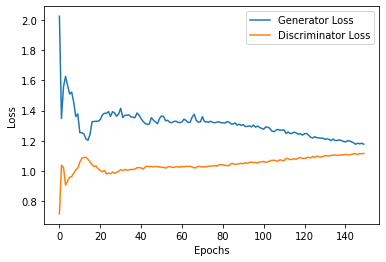

In [0]:
# Plots.
plt.plot([i for i in range(EPOCHS)], [sum(gen_losses[i]) / len(gen_losses[i]) for i in range(EPOCHS)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot([i for i in range(EPOCHS)], [sum(disc_losses[i]) / len(disc_losses[i]) for i in range(EPOCHS)])
plt.legend(['Generator Loss', 'Discriminator Loss'], loc='upper right')

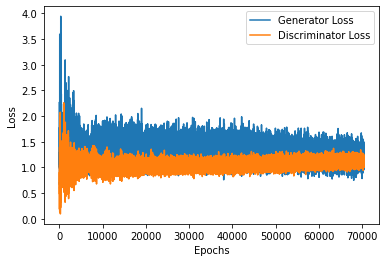

In [0]:
generator_losses = list()
for i in range(EPOCHS):
  for loss in gen_losses[i]:
    generator_losses.append(loss)
discriminator_losses = list()
for i in range(EPOCHS):
  for loss in disc_losses[i]:
    discriminator_losses.append(loss)
plt.plot([i for i in range(len(generator_losses))], [generator_losses[i] for i in range(len(generator_losses))])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot([i for i in range(len(discriminator_losses))], [discriminator_losses[i] for i in range(len(discriminator_losses))])
plt.legend(['Generator Loss', 'Discriminator Loss'], loc='upper right')